In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl

import pandas as pd
import numpy as np
import joblib
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection

# break

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, input_cols, cond_cols, target):
        self.inputs = torch.FloatTensor(data[input_cols].to_numpy())
        self.conds = torch.FloatTensor(dadta[cond_cols].to_numpy())
        self.target = torch.FloatTensor(data[target].to_numpy())
    
    def __getitem__(self, i):
        return self.inputs[i], self.conds[i], self.target[i]

    def __len__(self):
        return len(self.target)

In [40]:
class CTRPDataModule(pl.LightningDataModule):

    def __init__(self, train, val, fold, input_cols, cond_cols, target, batch_size=32):
        super().__init__()
        self.train = train
        self.val = val
        self.fold = fold
        self.input_cols = input_cols
        self.cond_cols = cond_cols
        self.target = target
        self.batch_size = batch_size

    # When doing distributed training, Datamodules have two optional arguments for
    # granular control over download/prepare/splitting data:
    def prepare_data(self):
        pass

    # OPTIONAL, called for every GPU/machine (assigning state is OK)
    def setup(self, stage):
        # transformations
        self.scaler = StandardScaler()
        self.train[self.input_cols] = self.scaler.fit_transform(self.train[self.input_cols])
        self.val[self.input_cols] = self.scaler.transform(self.val[self.input_cols])
        
        if stage == 'fit':
            self.train_dataset = Dataset(self.train, self.input_cols, self.cond_cols, self.target)
            self.val_dataset = Dataset(self.val, self.input_cols, self.cond_cols, self.target)
            return self.train_dataset, self.val_dataset
        if stage == 'test':
            self.test_dataset = Dataset(self.test, self.input_cols, self.cond_cols, self.target)
            return self.test_dataset

    # return the dataloader for each split
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=8, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [1]:
def prepare(exp, subset=True):
    data_path = Path("../../film-gex-data/processed/")
    input_cols = joblib.load(data_path.joinpath("gene_cols.pkl"))
    
    if exp=='id':
        cpd_id = "master_cpd_id"
        cond_cols = np.array([cpd_id, 'cpd_conc_umol'])
    else:
        fp_cols = joblib.load(data_path.joinpath("fp_cols.pkl"))
        cond_cols = np.append(fp_cols, ['cpd_conc_umol'])
        
    if subset:
        dataset = ds.dataset(data_path.joinpath("train_sub.feather"), format='feather')
    else:
        dataset = ds.dataset(data_path.joinpath("train.feather"), format='feather')

    return dataset, input_cols, cond_cols

In [2]:
## Read data
# Paths
ds_path = Path("../../film-gex-data/drug_screens/")
cm_path = Path("../../film-gex-data/cellular_models/")
out_path = Path("../../film-gex-data/processed/")
# CCLE
meta_ccle = pd.read_csv(cm_path.joinpath("sample_info.csv"))
ccle = pd.read_csv(cm_path.joinpath("CCLE_expression.csv"), index_col=0)
# L1000 genes
genes = pd.read_csv(cm_path.joinpath("GSE70138_Broad_LINCS_gene_info_2017-03-06.txt.gz"), sep="\t", index_col=0)
# CTRP
cp_ctrp = pd.read_csv(ds_path.joinpath("CTRP/v20.meta.per_compound.txt"), sep="\t", index_col=0)
cl_ctrp = pd.read_csv(ds_path.joinpath("CTRP/v20.meta.per_cell_line.txt"), sep="\t", index_col=0)
exp_ctrp = pd.read_csv(ds_path.joinpath("CTRP/v20.meta.per_experiment.txt"), sep="\t", index_col=0)
ctrp = pd.read_csv(ds_path.joinpath("CTRP/v20.data.per_cpd_post_qc.txt") ,sep='\t', index_col=0)

/srv/home/wconnell/anaconda3/envs/lightning/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
exp_ctrp.head()

,run_id,experiment_date,culture_media,baseline_signal,cells_per_well,growth_mode,snp_fp_status,master_ccl_id
experiment_id,,,,,,,,
1,7024-01-A01-02-01,20120501,DMEM001,0.2225,500,adherent,SNP-matched-reference,130
2,7024-01-A01-02-01,20120501,DMEM001,0.2225,500,adherent,SNP-matched-reference,569
3,7024-01-A01-02-01,20120501,RPMI001,0.1195,500,adherent,SNP-matched-reference,682
4,7024-01-A01-02-02,20120504,DMEM001,0.2225,500,adherent,SNP-unconfirmed,9
5,7024-01-A01-02-02,20120504,DMEM001,0.2225,500,adherent,SNP-matched-reference,61


In [5]:
cl_ctrp.head()

,ccl_name,ccl_availability,ccle_primary_site,ccle_primary_hist,ccle_hist_subtype_1
master_ccl_id,,,,,
1,697,ccle;public,haematopoietic_and_lymphoid_tissue,lymphoid_neoplasm,acute_lymphoblastic_B_cell_leukaemia
3,5637,ccle;public,urinary_tract,carcinoma,NaN
4,2313287,ccle;public,stomach,carcinoma,adenocarcinoma
5,1321N1,ccle,central_nervous_system,glioma,astrocytoma
6,143B,ccle,bone,osteosarcoma,NaN


In [6]:
ctrp.head()

,cpd_pv_errorbar,cpd_pred_pv,cpd_avg_pv,cpd_conc_umol,master_cpd_id
experiment_id,,,,,
1,0.000058,1.0,0.9303,0.00030,1788
1,0.000058,1.0,0.8337,0.00061,1788
1,0.000058,1.0,1.0460,0.00120,1788
1,0.000058,1.0,1.0910,0.00240,1788
1,0.000058,1.0,1.0190,0.00490,1788


In [7]:
from scipy.integrate import simps

In [8]:
test = ctrp[(ctrp.index==1) & (ctrp['master_cpd_id']==1788)]

In [14]:
simps(y=test['cpd_pred_pv'], x=test['cpd_conc_umol'])

7.8520437916666666

In [20]:
ctrp_auc = ctrp.reset_index().groupby(['experiment_id', 'master_cpd_id']).apply(lambda grp: simps(y=grp['cpd_pred_pv'], x=grp['cpd_conc_umol']))

In [22]:
ctrp_auc.reset_index()

,experiment_id,master_cpd_id,0
0,1,1788,7.852044
1,1,3588,81.942850
2,1,12877,38.386128
3,1,19153,110.412857
4,1,23256,22.256614
...,...,...,...
395258,907,688975,6.724182
395259,907,689136,36.310634
395260,907,689506,5.575097
395261,907,705300,29.834396


<AxesSubplot:xlabel='cpd_conc_umol'>

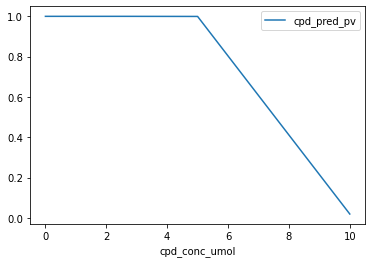

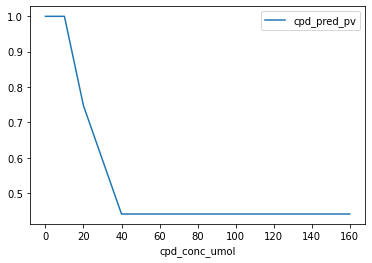

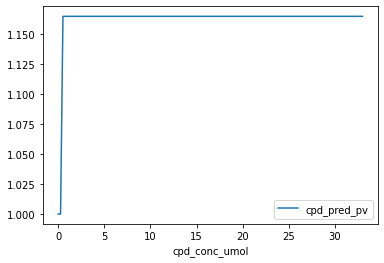

In [28]:
ctrp[ctrp['master_cpd_id']==1788].loc[1].plot('cpd_conc_umol', 'cpd_pred_pv')
ctrp[ctrp['master_cpd_id']==3588].loc[1].plot('cpd_conc_umol', 'cpd_pred_pv')
ctrp[ctrp['master_cpd_id']==12877].loc[1].plot('cpd_conc_umol', 'cpd_pred_pv')

In [30]:
ctrp.reset_index().groupby(['experiment_id', 'master_cpd_id']).size().value_counts()

16    319236
15     39154
14     16910
13      7652
12      5485
11      2255
8       1431
10      1398
9        907
17       720
29        84
28        12
25         8
24         4
27         3
23         2
26         2
dtype: int64

<AxesSubplot:>

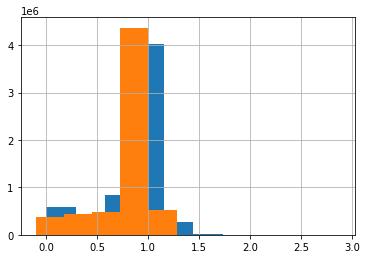

In [34]:
ctrp['cpd_avg_pv'].hist()
ctrp['cpd_pred_pv'].hist()

In [35]:
ctrp[ctrp['cpd_pred_pv'] < 0]

,cpd_pv_errorbar,cpd_pred_pv,cpd_avg_pv,cpd_conc_umol,master_cpd_id
experiment_id,,,,,
1,0.2658,-0.004068,0.012780,100.0,26972
1,0.5276,-0.018670,0.030480,170.0,28452
1,0.1708,-0.008464,0.011060,33.0,50715
1,0.2097,-0.050210,0.013020,66.0,349002
1,0.2274,-0.027140,0.017170,300.0,411731
...,...,...,...,...,...
907,0.2639,-0.029330,0.024970,37.0,375264
907,0.1918,-0.093130,0.005087,37.0,411808
907,0.2035,-0.051600,0.028950,66.0,606136


In [45]:
for f in range(5):
    print(f)

0
1
2
3
4
